## This page uses compares logistic regression and other classification models for modeling several economic variables from census data to understand the drivers of voting results.

Classification models:
- Logistic regression

In [423]:
# imports
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
import warnings

In [39]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
np.random.seed(42)

In [301]:
# modeling imports
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Logistic Regression classifier, to learn feature importance.

Y = outcome of congressional vote:  
- 0 = REP, because has traditionally been the baseline.
- 1 = DEM, because this is a new trend.

#### Bring in transformed data set, which combines voting and census data for each precinct

In [41]:
df = pd.read_pickle('./data/combined18_extended.pkl')
df.shape

(1334, 37)

In [42]:
df.head()

,srprec_orig,subindex,pctsrprec_tract,employed_wgt,unemployed_wgt,empl_military_wgt,not_inlaborforce_wgt,working_women_wgt,parents_work_under6_wgt,parents_work_0617_wgt,...,totreg_r,dem,rep,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
0,2001.0,3.0,100.0,2647.0,161.0,0.0,1372.0,1152.0,268.0,783.0,...,371.0,161.0,106.0,83.0,173.0,198.0,106.0,20.0,56.0,7.0
1,2002.0,0.0,100.0,2881.0,217.0,9.0,1525.0,1030.0,257.0,1082.0,...,109.0,61.0,8.0,39.0,46.0,63.0,52.0,0.0,23.0,0.0
2,2008.0,0.0,100.0,3948.0,278.0,0.0,1438.0,1656.0,561.0,677.0,...,1197.0,621.0,234.0,301.0,574.0,623.0,376.0,60.0,171.0,12.0
3,2009.0,3.0,100.0,3045.0,147.0,0.0,2459.0,1447.0,273.0,717.0,...,735.0,380.0,177.0,160.0,359.0,376.0,169.0,39.0,54.0,1.0
4,2011.0,0.0,100.0,2991.0,74.0,0.0,1401.0,1486.0,334.0,492.0,...,805.0,251.0,360.0,167.0,415.0,390.0,59.0,29.0,30.0,5.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1333
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   srprec_orig               1334 non-null   float64
 1   subindex                  1334 non-null   float64
 2   pctsrprec_tract           1334 non-null   float64
 3   employed_wgt              1334 non-null   float64
 4   unemployed_wgt            1334 non-null   float64
 5   empl_military_wgt         1334 non-null   float64
 6   not_inlaborforce_wgt      1334 non-null   float64
 7   working_women_wgt         1334 non-null   float64
 8   parents_work_under6_wgt   1334 non-null   float64
 9   parents_work_0617_wgt     1334 non-null   float64
 10  occ_mgmt_sci_art_wgt      1334 non-null   float64
 11  occ_service_sector_wgt    1334 non-null   float64
 12  occ_sales_gen_office_wgt  1334 non-null   float64
 13  occ_constr_maintc_wgt     1334 non-null   float64
 14  occ_manu

In [44]:
df['srprec_orig'] = df['srprec_orig'].astype('int64')

In [45]:
df['cddist'].value_counts()

45    347
48    334
39    226
46    198
47    133
49     87
38      9
Name: cddist, dtype: int64

### Define X and y from voter data (can enhance with census data later on)

#### define y

In [46]:
# create a categorical column where CNGREP01 < CNGDEM01  (where Democrat wins, since Dems were victorious in 2018)

In [47]:
y_raw18 = combo[['CNGDEM01', 'CNGREP01']]
y_raw18.head()

,CNGDEM01,CNGREP01
0,249,126
1,100,17
2,929,295
3,515,229
4,368,439


In [48]:
y_raw18.describe()

,CNGDEM01,CNGREP01
count,1334.000000,1334.000000
mean,435.853073,368.841829
std,301.603744,284.835099
min,0.000000,0.000000
25%,187.750000,129.250000
50%,415.000000,327.500000
75%,641.000000,566.750000
max,1806.000000,1475.000000


In [49]:
y_raw18['dem_win'] = combo['CNGDEM01'] > combo['CNGREP01']
# will return a slice-of-dataframe warning, OK to proceed

<ipython-input-49-fc75eef615fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw18['dem_win'] = combo['CNGDEM01'] > combo['CNGREP01']


In [50]:
y_raw18

,CNGDEM01,CNGREP01,dem_win
0,249,126,True
1,100,17,True
2,929,295,True
3,515,229,True
4,368,439,False
...,...,...,...
1329,225,495,False
1330,28,49,False
1331,93,154,False
1332,75,173,False


In [58]:
y_raw18['dem_win'].value_counts(normalize=True)
#slightly unbalanced 60/40, but not horrible

1    0.604948
0    0.395052
Name: dem_win, dtype: float64

In [52]:
y_raw18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CNGDEM01  1334 non-null   int64
 1   CNGREP01  1334 non-null   int64
 2   dem_win   1334 non-null   bool 
dtypes: bool(1), int64(2)
memory usage: 32.6 KB


In [53]:
y_raw18['dem_win'] = y_raw18['dem_win'].astype(int)
# will return a slice-of-dataframe warning, OK to proceed

<ipython-input-53-8b3119850fea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_raw18['dem_win'] = y_raw18['dem_win'].astype(int)


In [54]:
y_raw18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1334 entries, 0 to 1333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CNGDEM01  1334 non-null   int64
 1   CNGREP01  1334 non-null   int64
 2   dem_win   1334 non-null   int64
dtypes: int64(3)
memory usage: 41.7 KB


In [67]:
y = y_raw18['dem_win']
y.head()

0    1
1    1
2    1
3    1
4    0
Name: dem_win, dtype: int64

In [112]:
y.to_pickle('./data/y.pkl')

In [60]:
df.columns.tolist()

['srprec_orig',
 'subindex',
 'pctsrprec_tract',
 'employed_wgt',
 'unemployed_wgt',
 'empl_military_wgt',
 'not_inlaborforce_wgt',
 'working_women_wgt',
 'parents_work_under6_wgt',
 'parents_work_0617_wgt',
 'occ_mgmt_sci_art_wgt',
 'occ_service_sector_wgt',
 'occ_sales_gen_office_wgt',
 'occ_constr_maintc_wgt',
 'occ_manuf_transpo_wgt',
 'hh_med_income_wgt',
 'hlthins_priv_wgt',
 'hlthins_public_wgt',
 'hlthins_none_wgt',
 'county',
 'srprec',
 'cddist',
 'TOTREG',
 'TOTVOTE',
 'CNGDEM01',
 'CNGREP01',
 'election',
 'totreg_r',
 'dem',
 'rep',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']

In [227]:
X = df[['employed_wgt',
 'unemployed_wgt',
 'empl_military_wgt',
 'not_inlaborforce_wgt',
 'working_women_wgt',
 'parents_work_under6_wgt',
 'parents_work_0617_wgt',
 'occ_mgmt_sci_art_wgt',
 'occ_service_sector_wgt',
 'occ_sales_gen_office_wgt',
 'occ_constr_maintc_wgt',
 'occ_manuf_transpo_wgt',
 'hh_med_income_wgt',
 'hlthins_priv_wgt',
 'hlthins_public_wgt',
 'hlthins_none_wgt',
#  'TOTREG',
#  'TOTVOTE',
#  'dem',
#  'rep',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']]


In [228]:
X.head()

,employed_wgt,unemployed_wgt,empl_military_wgt,not_inlaborforce_wgt,working_women_wgt,parents_work_under6_wgt,parents_work_0617_wgt,occ_mgmt_sci_art_wgt,occ_service_sector_wgt,occ_sales_gen_office_wgt,...,hlthins_priv_wgt,hlthins_public_wgt,hlthins_none_wgt,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
0,2647.0,161.0,0.0,1372.0,1152.0,268.0,783.0,244.0,637.0,706.0,...,2156.0,2846.0,1050.0,83.0,173.0,198.0,106.0,20.0,56.0,7.0
1,2881.0,217.0,9.0,1525.0,1030.0,257.0,1082.0,363.0,573.0,383.0,...,1885.0,3583.0,1700.0,39.0,46.0,63.0,52.0,0.0,23.0,0.0
2,3948.0,278.0,0.0,1438.0,1656.0,561.0,677.0,675.0,796.0,1064.0,...,3947.0,2926.0,1356.0,301.0,574.0,623.0,376.0,60.0,171.0,12.0
3,3045.0,147.0,0.0,2459.0,1447.0,273.0,717.0,693.0,701.0,912.0,...,3794.0,2708.0,822.0,160.0,359.0,376.0,169.0,39.0,54.0,1.0
4,2991.0,74.0,0.0,1401.0,1486.0,334.0,492.0,1364.0,331.0,1011.0,...,4400.0,1523.0,259.0,167.0,415.0,390.0,59.0,29.0,30.0,5.0


In [229]:
X.to_pickle('./data/X.pkl')

#### run the extended dataset through LogReg, no scaling


In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head(3)

,employed_wgt,unemployed_wgt,empl_military_wgt,not_inlaborforce_wgt,working_women_wgt,parents_work_under6_wgt,parents_work_0617_wgt,occ_mgmt_sci_art_wgt,occ_service_sector_wgt,occ_sales_gen_office_wgt,...,hlthins_priv_wgt,hlthins_public_wgt,hlthins_none_wgt,dcl,male,female,hispdem,hisprep,hispdcl,hispoth
1188,4875.0,253.0,0.0,1959.0,2191.0,711.0,1432.0,3132.0,286.0,1234.0,...,10202.0,750.0,205.0,323.0,653.0,651.0,44.0,23.0,32.0,7.0
906,2414.0,127.0,0.0,1811.0,1088.0,165.0,321.0,1518.0,175.0,613.0,...,4552.0,1566.0,125.0,315.0,750.0,915.0,12.0,17.0,8.0,1.0
1018,2771.0,115.0,0.0,1595.0,1284.0,178.0,326.0,1347.0,443.0,690.0,...,3846.0,1714.0,538.0,232.0,398.0,510.0,58.0,27.0,31.0,3.0


In [231]:
import sklearn

In [232]:
logreg = LogisticRegression(n_jobs=-1, max_iter=10_000)

In [233]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1)

In [234]:
logreg.score(X_train, y_train)

0.644

In [235]:
logreg.score(X_test, y_test)

0.6227544910179641

In [236]:
f1_train = f1_score(y_train, logreg.predict(X_train))
f1_test = f1_score(y_test, logreg.predict(X_test))
overfit = f1_train > f1_test
round(f1_train, 4), round(f1_test, 4), overfit

(0.7482, 0.7225, True)

In [237]:
# vs. null model?  
y_test.value_counts(normalize=True)

# our logreg score (65%) is slightly better than null model (60%), but not great.  

1    0.598802
0    0.401198
Name: dem_win, dtype: float64

#### Examine feature importance:

In [238]:
logreg.coef_

array([[ 2.73062790e-04,  3.28093020e-05, -6.18180689e-07,
         1.14545012e-04,  1.21383732e-04,  2.63810420e-05,
         4.88003301e-05, -1.76864673e-04,  1.88022236e-04,
         3.33904056e-05,  7.07877980e-05,  1.57667542e-04,
         4.67320959e-09, -3.80476651e-04,  5.59073947e-04,
         2.72590160e-04,  2.14184811e-05, -3.55028210e-06,
         1.27873781e-08,  6.15002512e-05,  7.93872389e-07,
         1.97685181e-05,  2.19532569e-06]])

In [239]:
np.exp(logreg.coef_)

array([[1.0002731 , 1.00003281, 0.99999938, 1.00011455, 1.00012139,
        1.00002638, 1.0000488 , 0.99982315, 1.00018804, 1.00003339,
        1.00007079, 1.00015768, 1.        , 0.9996196 , 1.00055923,
        1.00027263, 1.00002142, 0.99999645, 1.00000001, 1.0000615 ,
        1.00000079, 1.00001977, 1.0000022 ]])

In [240]:
features = X.columns.to_list()
features

['employed_wgt',
 'unemployed_wgt',
 'empl_military_wgt',
 'not_inlaborforce_wgt',
 'working_women_wgt',
 'parents_work_under6_wgt',
 'parents_work_0617_wgt',
 'occ_mgmt_sci_art_wgt',
 'occ_service_sector_wgt',
 'occ_sales_gen_office_wgt',
 'occ_constr_maintc_wgt',
 'occ_manuf_transpo_wgt',
 'hh_med_income_wgt',
 'hlthins_priv_wgt',
 'hlthins_public_wgt',
 'hlthins_none_wgt',
 'dcl',
 'male',
 'female',
 'hispdem',
 'hisprep',
 'hispdcl',
 'hispoth']

In [394]:
logreg_coef = pd.DataFrame({'columns':features, 'coef':logreg.coef_[0]})


In [395]:
viz = logreg_coef.sort_values('coef')
viz

,columns,coef
13,hlthins_priv_wgt,-3.804767e-04
7,occ_mgmt_sci_art_wgt,-1.768647e-04
17,male,-3.550282e-06
2,empl_military_wgt,-6.181807e-07
12,hh_med_income_wgt,4.673210e-09
18,female,1.278738e-08
20,hisprep,7.938724e-07
22,hispoth,2.195326e-06
21,hispdcl,1.976852e-05
16,dcl,2.141848e-05


In [385]:
viz['columns'].tolist()

['hlthins_priv_wgt',
 'occ_mgmt_sci_art_wgt',
 'male',
 'empl_military_wgt',
 'hh_med_income_wgt',
 'female',
 'hisprep',
 'hispoth',
 'hispdcl',
 'dcl',
 'parents_work_under6_wgt',
 'unemployed_wgt',
 'occ_sales_gen_office_wgt',
 'parents_work_0617_wgt',
 'hispdem',
 'occ_constr_maintc_wgt',
 'not_inlaborforce_wgt',
 'working_women_wgt',
 'occ_manuf_transpo_wgt',
 'occ_service_sector_wgt',
 'hlthins_none_wgt',
 'employed_wgt',
 'hlthins_public_wgt']

In [401]:
viz['features'] = ['private health ins',
                   'occup: management',
                   'male',
                   'empl: military',
                   'household median income',
                   'female',
                   'Hispanic GOP registered',
                   'Hispanic Other registered',
                   'Hispanic no party affil',
                   'No party affiliation',
                   'Both parents work, children under 6',
                   'Unemployed',
                   'occup: Sales, Office',
                   'Both parents work, children 6-17 yo',
                   'Hispanic DEM registered',
                   'occup: construction',
                   'not in laborforce',
                   'working women',
                   'occup: transport',
                   'occup: service sector',
                   'no health ins',
                   'employed',
                   'public health ins']


In [402]:
viz

,columns,coef,features
13,hlthins_priv_wgt,-3.804767e-04,private health ins
7,occ_mgmt_sci_art_wgt,-1.768647e-04,occup: management
17,male,-3.550282e-06,male
2,empl_military_wgt,-6.181807e-07,empl: military
12,hh_med_income_wgt,4.673210e-09,household median income
18,female,1.278738e-08,female
20,hisprep,7.938724e-07,Hispanic GOP registered
22,hispoth,2.195326e-06,Hispanic Other registered
21,hispdcl,1.976852e-05,Hispanic no party affil
16,dcl,2.141848e-05,No party affiliation


In [404]:
viz.drop(columns='columns', inplace=True)

In [406]:
viz.rename(columns={'coef': 'importance'}, inplace=True)

In [409]:
vizviz = viz[['features', 'importance']].loc[viz['importance'] > 4.880033e-05]

In [411]:
vizviz.sort_values('importance')

,features,importance
6,"Both parents work, children 6-17 yo",0.000049
19,Hispanic DEM registered,0.000062
10,occup: construction,0.000071
3,not in laborforce,0.000115
4,working women,0.000121
11,occup: transport,0.000158
8,occup: service sector,0.000188
15,no health ins,0.000273
0,employed,0.000273
14,public health ins,0.000559


Text(0, 0.5, 'feature')

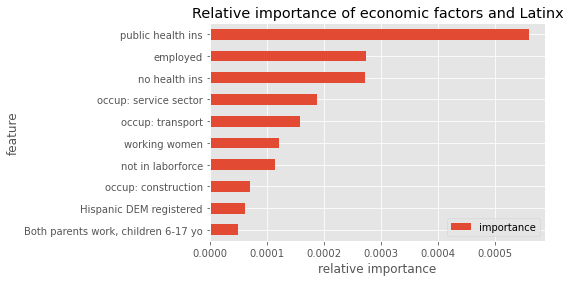

In [412]:
vizviz.plot(kind='barh', x='features', y='importance').legend(
    loc='best', ncol=3)
plt.title("Relative importance of economic factors and Latinx")
plt.xlabel("relative importance")
plt.ylabel("feature")
# plt.figure(figsize=(25, 10))
# plt.yticks(viz['columns'].tolist());

In [244]:
# model evaluation scores are below.

#### Conclusions:
1. overfits
2. lower model scores (approx 60%) vs voting data only (approx 90%) (party affiliation, gender, etc.).

#### scale the data because they are not on the same scale:
1. `hh_med_income_wgt` is in dollars
2. other fields are expressed as population numbers, however may be of different scales. best to standardize the scale of the data

In [245]:
ss = StandardScaler()

In [246]:
#estimators
logreg2 = LogisticRegression()
dtree = DecisionTreeClassifier()
hist = HistGradientBoostingClassifier()

In [247]:
ss_logreg2 = make_pipeline(ss, logreg2)
ss_dtree = make_pipeline(ss, dtree)
ss_hist = make_pipeline(ss, hist)
for est in (ss_logreg2, ss_dtree, ss_hist):
    est.fit(X_train, y_train)
    print(f'The Score on the train data is: {est.score(X_train, y_train)}')
    print(f'The Score on the test data is: {est.score(X_test, y_test)}')


The Score on the train data is: 0.845
The Score on the test data is: 0.8532934131736527
The Score on the train data is: 1.0
The Score on the test data is: 0.7365269461077845
The Score on the train data is: 0.999
The Score on the test data is: 0.8502994011976048


**OBSERVATIONS**
- Gradient Boost also has decent results on test data:  85%
- For LogReg, scaling the data greatly improved the scores, from approx 65% to 85%

### Further tuning via feature selection (Polynomial Features, Select K Best, Decision Tree)

#### Polynomial features with logistic regression
**RESULT** Overfits the data, by a lot

In [248]:
pf = PolynomialFeatures()
logreg3 = LogisticRegression(max_iter=10_000)

In [249]:
pf_logreg3 = make_pipeline(ss, pf, logreg3)

pf_logreg3.fit(X_train, y_train)
print(f'The Score on the train data is: {est.score(X_train, y_train)}')
print(f'The Score on the test data is: {est.score(X_test, y_test)}')

The Score on the train data is: 0.999
The Score on the test data is: 0.8502994011976048


In [253]:
# DataFrame of coefficients
# pd.DataFrame(list(zip(X.columns, logreg3.coef_)))

#### Select K best features
Grid Search over a few options

In [346]:
ss4 = StandardScaler()
pf4 = PolynomialFeatures()
select = SelectKBest()
logreg4 = LogisticRegression()

In [347]:
pf_logreg4 = make_pipeline(ss4, pf4, select, logreg4)

In [348]:
params = {
    'selectkbest__k': range(5,10,15),
    'logisticregression__penalty': ['none', 'l2'],
    'logisticregression__max_iter':[100000]
}

In [349]:
gs = GridSearchCV(pf_logreg4, param_grid=params)
gs.fit(X_train, y_train)

#returns a warning regarding ("Features %s are constant.")
# very little data in X_train['empl_military_wgt'] ... OK to ignore

/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features 

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__max_iter': [100000],
                         'logisticregression__penalty': ['none', 'l2'],
                         'selectkbest__k': range(5, 10, 15)})

In [350]:
X_train['empl_military_wgt'].value_counts()

0.0      828
10.0      14
4.0       12
2.0       11
5.0       11
16.0       9
6.0        9
3.0        8
14.0       8
13.0       7
17.0       7
9.0        7
1.0        6
8.0        6
7.0        5
12.0       5
29.0       4
18.0       4
33.0       4
15.0       4
30.0       3
25.0       3
57.0       3
44.0       3
24.0       3
19.0       2
26.0       2
49.0       2
116.0      2
27.0       1
35.0       1
11.0       1
40.0       1
20.0       1
41.0       1
36.0       1
32.0       1
Name: empl_military_wgt, dtype: int64

In [351]:
print('Train Best', gs.best_score_)
print('Test Score', gs.score(X_test, y_test))
print(gs.best_params_)
print(gs.best_estimator_)


Train Best 0.716
Test Score 0.7335329341317365
{'logisticregression__max_iter': 100000, 'logisticregression__penalty': 'none', 'selectkbest__k': 5}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest', SelectKBest(k=5)),
                ('logisticregression',
                 LogisticRegression(max_iter=100000, penalty='none'))])


### Decision Tree to highlight important features

In [358]:
# Instantiate model with random_state = 42.
dtree5 = DecisionTreeClassifier(random_state=42)

In [359]:
ss5 = StandardScaler()

In [366]:
#scale X
X_train_ss5 = ss5.fit_transform(X_train)
X_test_ss5 = ss5.transform(X_test)

In [367]:
dtree5.fit(X_train_ss5, y_train)

DecisionTreeClassifier(random_state=42)

In [371]:
params = {'max_depth': [2,3,5,7],
          'min_samples_split': [5, 10, 15, 20], 
          'min_samples_leaf': [2,3,4,5,6], 
          'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]}

In [373]:
grid5 = GridSearchCV(dtree5, param_grid=params)
grid5.fit(X_train_ss5, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                         'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20]})

In [374]:
grid5.best_params_

{'ccp_alpha': 0.001,
 'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 5}

In [268]:
# # DataFrame of coefficients
# pd.DataFrame(list(zip(X.columns, grid5.best_estimator_.coef_)))

In [269]:
dtree5best = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001, max_depth=7, min_samples_leaf=4, min_samples_split=5)

In [375]:
dtree5best.fit(X_train_ss5, y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_leaf=3,
                       min_samples_split=5, random_state=42)

In [376]:
dtree5best.feature_importances_

array([0.        , 0.00929989, 0.        , 0.        , 0.03572551,
       0.04184952, 0.        , 0.        , 0.        , 0.        ,
       0.03468657, 0.01998402, 0.50711497, 0.01808109, 0.        ,
       0.06610596, 0.00545657, 0.        , 0.        , 0.06666708,
       0.10016947, 0.09485934, 0.        ])

In [377]:
viz_dtree5best = pd.DataFrame({'features': X_train.columns,
              'importances':dtree5best.feature_importances_}).sort_values('importances')
viz_dtree5best

,features,importances
0,employed_wgt,0.000000
18,female,0.000000
17,male,0.000000
14,hlthins_public_wgt,0.000000
9,occ_sales_gen_office_wgt,0.000000
8,occ_service_sector_wgt,0.000000
7,occ_mgmt_sci_art_wgt,0.000000
22,hispoth,0.000000
3,not_inlaborforce_wgt,0.000000
2,empl_military_wgt,0.000000


In [413]:
vizdtree = viz_dtree5best.loc[viz_dtree5best['importances'] > 0.01]

Text(0, 0.5, 'feature')

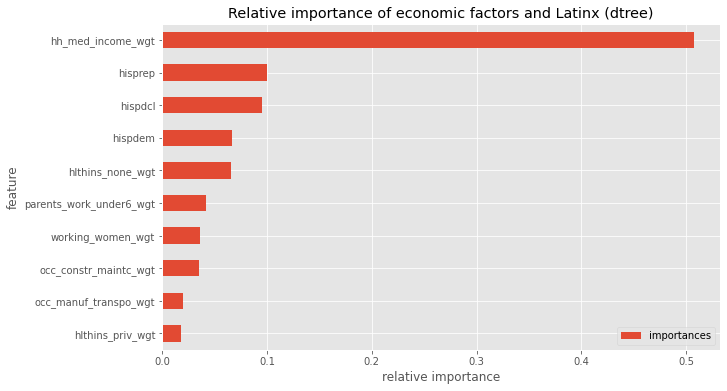

In [418]:
fig, ax = plt.subplots(figsize=(10,6))
vizdtree.plot(kind='barh', x='features', y='importances', ax=ax).legend(
    loc='best', ncol=3)
plt.title("Relative importance of economic factors and Latinx (dtree)")
plt.xlabel("relative importance")
plt.ylabel("feature")
# plt.yticks(viz['columns'].tolist());

In [273]:
# Import export_text from sklearn.tree module.
from sklearn.tree import export_text

# Print out tree in plaintext.
print(export_text(grid5.best_estimator_,
                  list(X_train.columns)))

|--- hh_med_income_wgt <= 88656.00
|   |--- hlthins_none_wgt <= 220.50
|   |   |--- parents_work_under6_wgt <= 140.00
|   |   |   |--- hlthins_priv_wgt <= 2927.00
|   |   |   |   |--- occ_service_sector_wgt <= 170.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- occ_service_sector_wgt >  170.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- hlthins_priv_wgt >  2927.00
|   |   |   |   |--- class: 0
|   |   |--- parents_work_under6_wgt >  140.00
|   |   |   |--- class: 0
|   |--- hlthins_none_wgt >  220.50
|   |   |--- hispdcl <= 1.50
|   |   |   |--- hispdem <= 7.50
|   |   |   |   |--- unemployed_wgt <= 155.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- unemployed_wgt >  155.00
|   |   |   |   |   |--- employed_wgt <= 3275.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- employed_wgt >  3275.50
|   |   |   |   |   |   |--- occ_service_sector_wgt <= 566.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- occ_service_sector_w

/Users/nevochka/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass feature_names=['employed_wgt', 'unemployed_wgt', 'empl_military_wgt', 'not_inlaborforce_wgt', 'working_women_wgt', 'parents_work_under6_wgt', 'parents_work_0617_wgt', 'occ_mgmt_sci_art_wgt', 'occ_service_sector_wgt', 'occ_sales_gen_office_wgt', 'occ_constr_maintc_wgt', 'occ_manuf_transpo_wgt', 'hh_med_income_wgt', 'hlthins_priv_wgt', 'hlthins_public_wgt', 'hlthins_none_wgt', 'dcl', 'male', 'female', 'hispdem', 'hisprep', 'hispdcl', 'hispoth'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


## Model evaluation

#### LogReg2, `accuracy = 0.85`
- logistic regression with scaled data
- standard scaler applied within a pipeline
- scores are generated from pipeline

In [306]:
# Instantiate and fit a logisitic regression model  
#above

# Check accuracy score on training data
print(f'The score on the train data is {ss_logreg2.score(X_train, y_train)}')
print(f'The score on the test data is {ss_logreg2.score(X_test, y_test)}')
# score = ss_logreg2.score(X_train, y_train)
# score

The score on the train data is 0.845
The score on the test data is 0.8532934131736527


In [309]:
# Make predictions on testing data
logreg2_preds = ss_logreg2.predict(X_test)
logreg2_preds[:5]

array([0, 1, 1, 1, 0])

In [318]:
# Generate confusion matrix
cm_logreg2 = confusion_matrix(y_test, logreg2_preds)
cm_logreg2.flatten()

array([112,  22,  27, 173])

In [314]:
# Extract tn, fp, fn, tp
tn, fp, fn, tp = cm_logreg2.ravel()

# Convert the values to a confusion matrix (multiple methods will work)
pd.DataFrame(cm_logreg2, columns=['Pred Neg', 'Pred Pos'], index=['Act Neg', 'Act Pos'])

def class_metrics(TP, TN, FP, FN):
    acc = (TP + TN) / (TP + FP + TN + FN)
    mis = 1 - acc
    sen = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    results = [acc, mis, sen, spec, prec]
    ## create dictionary for easy display of results
    names = ['accuracy', 'misclassification', 'sensitivity', 'specificity', 'precision']
    res_dict = dict(zip(names, results))
    return res_dict

class_metrics(tp, tn, fp, fn)


{'accuracy': 0.8532934131736527,
 'misclassification': 0.1467065868263473,
 'sensitivity': 0.865,
 'specificity': 0.835820895522388,
 'precision': 0.8871794871794871}

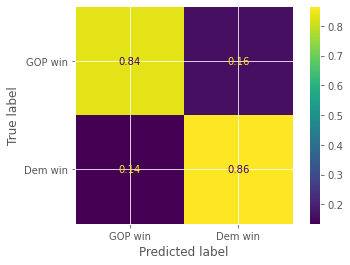

In [424]:
plot_confusion_matrix(ss_logreg2, X_test, y_test, display_labels=['GOP win', 'Dem win'], normalize='true');


#### dtree, `accuracy = 0.736`
- Decision Tree with scaled data
- standard scaler applied within a pipeline
- scores are generated from pipeline
- the intent of running this model is more for feature importance, but scoring the model neverthless
- Decision Tree will yield very high scores, but are typically very overfit, and cannot handle new data.

In [323]:
# Instantiate and fit a decision tree model 
#above

# Check accuracy score on training data
print(f'The score on the train data is {ss_dtree.score(X_train, y_train)}')
print(f'The score on the test data is {ss_dtree.score(X_test, y_test)}')

The score on the train data is 1.0
The score on the test data is 0.7365269461077845


In [324]:
# Make predictions on testing data
dtree_preds = ss_dtree.predict(X_test)
dtree_preds[:5]

array([1, 1, 1, 1, 0])

In [325]:
# Generate confusion matrix
cm_dtree = confusion_matrix(y_test, dtree_preds)
cm_dtree.flatten()

array([ 91,  43,  45, 155])

In [334]:
# Extract tn, fp, fn, tp
tn, fp, fn, tp = cm_dtree.ravel()

# Convert the values to a confusion matrix (multiple methods will work)
pd.DataFrame(cm_dtree, columns=['Pred Neg', 'Pred Pos'], index=['Act Neg', 'Act Pos'])

def class_metrics(TP, TN, FP, FN):
    acc = (TP + TN) / (TP + FP + TN + FN)
    mis = 1 - acc
    sen = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    results = [acc, mis, sen, spec, prec]
    ## create dictionary for easy display of results
    names = ['accuracy', 'misclassification', 'sensitivity', 'specificity', 'precision']
    res_dict = dict(zip(names, results))
    return res_dict

class_metrics(tp, tn, fp, fn)

{'accuracy': 0.7365269461077845,
 'misclassification': 0.26347305389221554,
 'sensitivity': 0.775,
 'specificity': 0.6791044776119403,
 'precision': 0.7828282828282829}

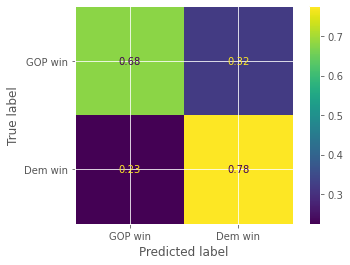

In [335]:
plot_confusion_matrix(ss_dtree, X_test, y_test, display_labels=['GOP win', 'Dem win'], normalize='true');

#### HistGradientBoost, `accuracy = 0.850`
- Gradient Boost classifier with scaled data
- standard scaler applied within a pipeline
- scores are generated from pipeline
- similar accuracy to Logistic Regression logreg2

In [329]:
# Instantiate and fit a Gradient Boost model 
#above

# Check accuracy score on training data
print(f'The score on the train data is {ss_hist.score(X_train, y_train)}')
print(f'The score on the test data is {ss_hist.score(X_test, y_test)}')

The score on the train data is 0.999
The score on the test data is 0.8502994011976048


In [330]:
# Make predictions on testing data
hist_preds = ss_hist.predict(X_test)
hist_preds[:5]

array([1, 1, 1, 1, 0])

In [331]:
# Generate confusion matrix
cm_hist = confusion_matrix(y_test, hist_preds)
cm_hist.flatten()

array([113,  21,  29, 171])

In [336]:
# Extract tn, fp, fn, tp
tn, fp, fn, tp = cm_hist.ravel()

# Convert the values to a confusion matrix (multiple methods will work)
pd.DataFrame(cm_hist, columns=['Pred Neg', 'Pred Pos'], index=['Act Neg', 'Act Pos'])

def class_metrics(TP, TN, FP, FN):
    acc = (TP + TN) / (TP + FP + TN + FN)
    mis = 1 - acc
    sen = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    results = [acc, mis, sen, spec, prec]
    ## create dictionary for easy display of results
    names = ['accuracy', 'misclassification', 'sensitivity', 'specificity', 'precision']
    res_dict = dict(zip(names, results))
    return res_dict

class_metrics(tp, tn, fp, fn)

{'accuracy': 0.8502994011976048,
 'misclassification': 0.14970059880239517,
 'sensitivity': 0.855,
 'specificity': 0.8432835820895522,
 'precision': 0.890625}

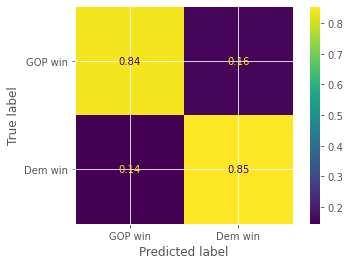

In [337]:
plot_confusion_matrix(ss_hist, X_test, y_test, display_labels=['GOP win', 'Dem win'], normalize='true');

#### logreg3, accuracy = 0.811
- Logistic Regression with scaled data and polynomial features
- standard scaler and poly-features applied within a pipeline
- scores are generated from pipeline
- poly-features accuracy score is less than without poly-features (logreg2, above)

In [344]:
# Instantiate and fit a Logistic Regression model 
#above

# Check accuracy score on training data
print(f'The score on the train data is {pf_logreg3.score(X_train, y_train)}')
print(f'The score on the test data is {pf_logreg3.score(X_test, y_test)}')

The score on the train data is 0.906
The score on the test data is 0.811377245508982


In [339]:
# Make predictions on testing data
logreg3_preds = pf_logreg3.predict(X_test)
logreg3_preds[:5]

array([0, 1, 1, 1, 0])

In [340]:
# Generate confusion matrix
cm_logreg3 = confusion_matrix(y_test, logreg3_preds)
cm_logreg3.flatten()

array([106,  28,  35, 165])

In [341]:
# Extract tn, fp, fn, tp
tn, fp, fn, tp = cm_logreg3.ravel()

# Convert the values to a confusion matrix (multiple methods will work)
pd.DataFrame(cm_logreg3, columns=['Pred Neg', 'Pred Pos'], index=['Act Neg', 'Act Pos'])

def class_metrics(TP, TN, FP, FN):
    acc = (TP + TN) / (TP + FP + TN + FN)
    mis = 1 - acc
    sen = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    results = [acc, mis, sen, spec, prec]
    ## create dictionary for easy display of results
    names = ['accuracy', 'misclassification', 'sensitivity', 'specificity', 'precision']
    res_dict = dict(zip(names, results))
    return res_dict

class_metrics(tp, tn, fp, fn)

{'accuracy': 0.811377245508982,
 'misclassification': 0.18862275449101795,
 'sensitivity': 0.825,
 'specificity': 0.7910447761194029,
 'precision': 0.8549222797927462}

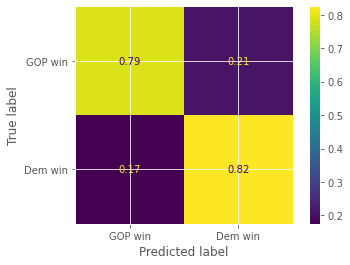

In [343]:
plot_confusion_matrix(pf_logreg3, X_test, y_test, display_labels=['GOP win', 'Dem win'], normalize='true');

#### logreg4, `accuracy = 0.734`
- Logistic Regression with scaled data and polynomial features with a gridsearch for Select K-Best number of features 
- standard scaler, poly-features, and select k-best applied within a pipeline
- then we do a grid search for different parameters for Select K-best features
- scores are generated from grid
- these scores are even lower than logistic regression alone

In [353]:
# Instantiate and fit a Logistic Regression model and Select K Best
#above

# Check accuracy score on training data
print(f'The score on the train data is {gs.score(X_train, y_train)}')
print(f'The score on the test data is {gs.score(X_test, y_test)}')

The score on the train data is 0.725
The score on the test data is 0.7335329341317365


In [354]:
# Make predictions on testing data
logreg4_preds = gs.predict(X_test)
logreg4_preds[:5]

array([0, 1, 1, 1, 1])

In [355]:
# Generate confusion matrix
cm_logreg4 = confusion_matrix(y_test, logreg4_preds)
cm_logreg4.flatten()

array([ 94,  40,  49, 151])

In [356]:
# Extract tn, fp, fn, tp
tn, fp, fn, tp = cm_logreg4.ravel()

# Convert the values to a confusion matrix (multiple methods will work)
pd.DataFrame(cm_logreg4, columns=['Pred Neg', 'Pred Pos'], index=['Act Neg', 'Act Pos'])

def class_metrics(TP, TN, FP, FN):
    acc = (TP + TN) / (TP + FP + TN + FN)
    mis = 1 - acc
    sen = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    results = [acc, mis, sen, spec, prec]
    ## create dictionary for easy display of results
    names = ['accuracy', 'misclassification', 'sensitivity', 'specificity', 'precision']
    res_dict = dict(zip(names, results))
    return res_dict

class_metrics(tp, tn, fp, fn)

{'accuracy': 0.7335329341317365,
 'misclassification': 0.2664670658682635,
 'sensitivity': 0.755,
 'specificity': 0.7014925373134329,
 'precision': 0.7905759162303665}

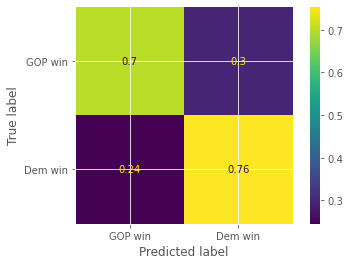

In [357]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['GOP win', 'Dem win'], normalize='true');

#### dtree5, accuracy = 0.___
- Decision Tree with gridsearch for best params to create a rank-order list of important features
- use these high-importance features to reduce the number of input features, to see if we get a better prediction result with Logistic Regression
- standard scaler, poly-features, and select k-best applied within a pipeline
- then we do a grid search for different parameters for Select K-best features
- scores are generated from grid
- these scores are even lower than logistic regression alone

In [419]:
# Check accuracy score on training data
print(f'The score on the train data is {dtree5best.score(X_train, y_train)}')
print(f'The score on the test data is {dtree5best.score(X_test, y_test)}')

The score on the train data is 0.607
The score on the test data is 0.5988023952095808


In [420]:
# Make predictions on testing data
dtree5best_preds = dtree5best.predict(X_test)
dtree5best_preds[:5]

array([1, 1, 1, 1, 1])

In [421]:
dtree5best_preds.sum()

334

In [422]:
len(dtree5best_preds)

334

In [ ]:

# Instantiate and fit a logisitic regression model (solver='liblinear')
log = LogisticRegression()
log.fit(X_train_ss, y_train)

# Check accuracy score on training data
score = log.score(X_train_ss, y_train)
score

# Make predictions on testing data
y_preds = log.predict(X_test_ss)
y_preds[:5]

# Generate confusion matrix
cm = confusion_matrix(y_test, y_preds)

cm.flatten()

# Extract tn, fp, fn, tp
tn, fp, fn, tp = cm.ravel()

# Convert the values to a confusion matrix (multiple methods will work)
pd.DataFrame(cm, columns=['Pred Neg', 'Pred Pos'], index=['Act Neg', 'Act Pos'])

def class_metrics(TP, TN, FP, FN):
    acc = (TP + TN) / (TP + FP + TN + FN)
    mis = 1 - acc
    sen = TP / (TP + FN)
    spec = TN / (TN + FP)
    prec = TP / (TP + FP)
    results = [acc, mis, sen, spec, prec]
    ## create dictionary for easy display of results
    names = ['accuracy', 'misclassification', 'sensitivity', 'specificity', 'precision']
    res_dict = dict(zip(names, results))
    return res_dict

class_metrics(tp, tn, fp, fn)



In [ ]:
preds = grid_mnb.predict(X_test)
preds

cmat_grid_mnb = confusion_matrix(y_test, preds)
cmat_grid_mnb

tn, fp, fn, tp = cmat_grid_mnb.ravel()
cmat_grid_mnb.ravel()

plot_confusion_matrix(grid_mnb, X_test, y_test, display_labels=['Star Wars', 'Game of Thrones'], normalize='true');


#### model-only rmse

In [161]:
def rmse_model(model):
    
    # calculate rmse scores
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    rmse_overfit = rmse_train < rmse_test
    
    # return rmse scores
    return f'for {model} rmse_train = {rmse_train}, and rmse_test = {rmse_test}.  Overfit = {rmse_overfit}'

In [163]:
# rmse_model(logreg2)
# # winner!  logistic regression w/ scaling
# # while overfit, it is not by that much

'for LogisticRegression() rmse_train = 0.6284902544988268, and rmse_test = 0.6381109846590285.  Overfit = True'

In [164]:
rmse_model(dtree)

'for DecisionTreeClassifier() rmse_train = 0.6164414002968976, and rmse_test = 0.6142031496028296.  Overfit = False'

In [165]:
rmse_model(hist)

'for HistGradientBoostingClassifier() rmse_train = 0.6024948132556828, and rmse_test = 0.5968981698327618.  Overfit = False'

In [166]:
rmse_model(logreg)

'for LogisticRegression(max_iter=10000, n_jobs=-1) rmse_train = 0.5477225575051661, and rmse_test = 0.5867805188019699.  Overfit = True'

In [168]:
def rmse_pipe(pipe):
    
    # calculate rmse scores
    rmse_train = np.sqrt(mean_squared_error(y_train, pipe.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, pipe.predict(X_test)))
    rmse_overfit = rmse_train < rmse_test
    
    # return rmse scores
    return f'for {pipe} rmse_train = {rmse_train}, and rmse_test = {rmse_test}.  Overfit = {rmse_overfit}'

In [169]:
rmse_pipe(ss_logreg2)
# logreg2 still a winner!  

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('logisticregression', LogisticRegression())]) rmse_train = 0.3065941943351178, and rmse_test = 0.3046545113033533.  Overfit = False"

In [170]:
rmse_pipe(ss_dtree)

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('decisiontreeclassifier', DecisionTreeClassifier())]) rmse_train = 0.0, and rmse_test = 0.4343072121102964.  Overfit = True"

In [171]:
rmse_pipe(ss_hist)

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('histgradientboostingclassifier',\n                 HistGradientBoostingClassifier())]) rmse_train = 0.0, and rmse_test = 0.3503633699717538.  Overfit = True"

In [173]:
rmse_pipe(pf_logreg3)

"for Pipeline(steps=[('standardscaler', StandardScaler()),\n                ('polynomialfeatures', PolynomialFeatures()),\n                ('logisticregression', LogisticRegression(max_iter=10000))]) rmse_train = 0.2449489742783178, and rmse_test = 0.33283395727265036.  Overfit = True"

In [181]:
def rmse_gs(grid):
    
    # calculate rmse scores
    rmse_train = np.sqrt(mean_squared_error(y_train, grid.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, grid.predict(X_test)))
    rmse_overfit = rmse_train < rmse_test
    
    # return rmse scores
    return f'for {grid} rmse_train = {rmse_train}, and rmse_test = {rmse_test}.  Overfit = {rmse_overfit}'

In [182]:
rmse_gs(gs)

"for GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),\n                                       ('polynomialfeatures',\n                                        PolynomialFeatures()),\n                                       ('selectkbest', SelectKBest()),\n                                       ('logisticregression',\n                                        LogisticRegression())]),\n             param_grid={'logisticregression__max_iter': [100000],\n                         'logisticregression__penalty': ['none', 'l2'],\n                         'selectkbest__k': range(5, 25, 100)}) rmse_train = 0.5244044240850758, and rmse_test = 0.5162044806743384.  Overfit = False"

In [211]:
rmse_gs(grid5)

"for GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),\n             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],\n                         'max_depth': [2, 3, 5, 7],\n                         'min_samples_leaf': [2, 3, 4, 5, 6],\n                         'min_samples_split': [5, 10, 15, 20]}) rmse_train = 0.3714835124201342, and rmse_test = 0.4343072121102964.  Overfit = True"

**CONCLUSION**

Loading all of these factors into a gridsearch removes the overfitting, however RMSE is much higher (52% vs 30% for logreg + standard scaler)